In [ ]:
from dataclasses import dataclass
import math
import random
import shortuuid
import typing
import pandas as pd
import subprocess
import os
import shutil
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
from matplotlib import ticker
import itertools
import cProfile
import pymc as pm
import arviz as az


## Simulation

In [2]:
def get_alpha_beta_from_mean_variance(mu, sigma):
    alpha = ((1-mu)/sigma**2 - 1/mu) * (mu)**2
    beta = alpha * (1/mu - 1)
    if alpha < 0:
        print('mu, sigma:', mu, sigma)
        print('alpha, beta: ', alpha, beta)
    return alpha, beta

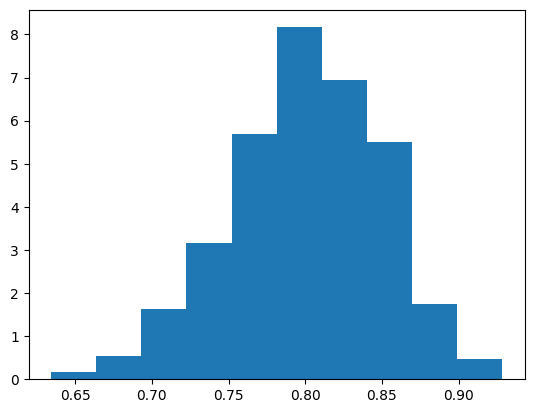

In [3]:
# example usage of function to create beta distribution

mu = 0.8
std = 0.05
alp, bet = get_alpha_beta_from_mean_variance(mu, std)
_ =  plt.hist(np.random.beta(alp, bet, size = 1000), density= True)

In [4]:
@dataclass
class Artist:
    id : str
    avg_characteristicness : float # not strictly bounded, but should sit in [0, 1]
    std_characteristicness : float 
    def create_real_ArtImage(self, subject):
        alpha, beta = get_alpha_beta_from_mean_variance(self.avg_characteristicness, self.std_characteristicness)
        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = False,
            characteristicness = np.random.beta(alpha, beta, size = None), # returns single value
            artist = self,
            creator = self,
            subject = subject
        )
    
@dataclass
class ArtImage:
    id: str
    is_ai: bool # whether the ArtImage is AI or real
    characteristicness: float # between 0 and 1
    artist: Artist
    creator: Artist
    subject: str

In [5]:
def score_diff_to_probability(diff): 
    return 1 / (1 + math.e**(diff))

In [6]:
@dataclass
class Participant:
    id: str
    skill: float # average value of 5 is reasonable (see calibration section below)

    def compare_two_ArtImages(self, ArtImage1 : ArtImage, ArtImage2 : ArtImage):
        diff = ArtImage2.characteristicness - ArtImage1.characteristicness
        prob = score_diff_to_probability(self.skill * diff)
        if random.uniform(0, 1) <= prob:
            return ArtImage1
        else:
            return ArtImage2

In [7]:
@dataclass
class ImageModel:
    id : str
    ability_to_mimic_style: float # [0,1]
    # this should only rarely be higher than an artist's own characteristicness
    
    def create_ai_ArtImage_matching_image(self, image: ArtImage, std_characteristicness: float) -> ArtImage:
        new_avg = self.ability_to_mimic_style * image.characteristicness
        alpha, beta = get_alpha_beta_from_mean_variance(new_avg, std_characteristicness)
        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = True,
            characteristicness=np.random.beta(alpha, beta, size = None),
            artist = image.artist,
            creator = self,
            subject = image.subject
        )

Specification of model:
$$ logit(P(i > j)) \sim (c_j + A ) - (c_i + A) $$
where $i$ and $j$ are different images. Note that $\sim$ indicates that the LHS is modelled by a linear combination of the RHS variables plus random noise.

And a more complex model:

$$ logit(P(i > j)) \sim (c_j + A_x ) - (c_i + A_y ) $$

where $x$ and $y$ are AI models. 

Incorporating entanglement:

$$ logit(P(i > j)) \sim (c_j + A_x + W_x ) - (c_i + A_y + W_y ) $$

where $W_x$ and $W_y$ are 1 if the subject is anachronistic

probability of one ArtImage being chosen: 

$$P(A > B) := \frac{e^{\lambda \cdot p_A} }{ e^{\lambda \cdot p_A} + e^{\lambda \cdot p_B} }  $$

where $S_x$ is the skill of the participant $x$. If $S_x$ is 

$$ P(A > B) := \frac{1}{1 + e^{\lambda \cdot ( p_B - p_A) }}  $$

## Bayesian method

In [60]:
def process_count_data_for_bayesian_methods(df):
    all_artworks = pd.unique(df[["real_artwork", "ai_artwork"]].values.ravel())
    id_map = {art: i for i, art in enumerate(all_artworks)}
    n_players = len(all_artworks)

    rows = []
    for _, row in df.iterrows():
        real_id = id_map[row["real_artwork"]]
        ai_id   = id_map[row["ai_artwork"]]
        # real wins
        rows += [(real_id, ai_id)] * int(row["real_win"])
        # ai wins
        rows += [(ai_id, real_id)] * int(row["ai_win"])

    pairwise = pd.DataFrame(rows, columns=["winner", "loser"])

    winner = pairwise["winner"].values
    loser  = pairwise["loser"].values

    is_ai = np.array([art in set(df["ai_artwork"]) for art in all_artworks]).astype(int)
    
    return winner, loser, is_ai

def extract_variables_from_pymc_results(trace, variables_of_interest):
    res_bayesian = az.summary(trace, var_names= variables_of_interest, hdi_prob=0.94)[['mean','hdi_3%','hdi_97%']].rename(
        columns={'hdi_3%': 'lower', 'hdi_97%': 'upper', 'mean':'estimate'}
    )
    res_bayesian['p_value'] = [np.mean(trace.posterior[var].values.flatten() > 0 ) for var in variables_of_interest]
    return res_bayesian

In [61]:
def run_bayesian_analysis(path_to_data, with_individual_effects):
    df = pd.read_csv(path_to_data)

    winner, loser, is_ai = process_count_data_for_bayesian_methods(df)

    if with_individual_effects:
        with pm.Model() as bt_cov_model:
            ability = pm.Normal("ability", mu=0, sigma=1, shape=n_players)
            ability_centered = ability - pm.math.mean(ability)

            beta_ai = pm.Normal("beta_ai", mu=0, sigma=1)

            logit_p = (
                ability_centered[winner] - ability_centered[loser]
                + beta_ai * (is_ai[winner] - is_ai[loser])
            )
            p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

            pm.Bernoulli("outcome", p=p, observed=np.ones(len(winner)))

            trace = pm.sample(1500, tune=1000, target_accept=0.9, random_seed=42)
    else:
        with pm.Model() as bt_cov_model:
            ability = pm.Normal("ability", mu=0, sigma=1, shape=n_players)
            ability_centered = ability - pm.math.mean(ability)

            beta_ai = pm.Normal("beta_ai", mu=0, sigma=1)

            logit_p = (
                beta_ai * (is_ai[winner] - is_ai[loser])
            )
            p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

            pm.Bernoulli("outcome", p=p, observed=np.ones(len(winner)))

            trace = pm.sample(1500, tune=1000, target_accept=0.9, random_seed=42)

    return extract_variables_from_pymc_results(trace, ['beta_ai'])
    
run_bayesian_analysis("/Users/daxmavy/oxford/art/simulations/data/test/sims/0.csv", False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 4 seconds.


,estimate,lower,upper,p_value
beta_ai,-0.358,-0.505,-0.2,0.0


## Running overall simulation

In [ ]:
def generate_data_for_simulation(
        filename,
        N_PARTICIPANTS = 40,
        avg_participant_skill = 1,
        std_participant_skill = 0.05,
        N_ARTISTS = 4, 
        avg_real_artist_characteristicness = 0.7,
        std_real_artist_characteristicness = 0.05,
        N_ARTWORKS_PER_ARTIST = 12, 
        Model_ABILITIES = [0.95, 0.9, 0.8, 0.5],
        N_TRIALS_PER_Model_IN_ARTIST_BLOCK = 1,
        num_subjects_per_artist = 1
):
    artists = [Artist(
        id=f'art~{shortuuid.uuid()}',
        avg_characteristicness=avg_real_artist_characteristicness,
        std_characteristicness=std_real_artist_characteristicness
    ) for _ in range(N_ARTISTS) ]

    real_artworks = []
    for artist in artists:
        subjects = itertools.cycle(range(num_subjects_per_artist))
        for _ in range(N_ARTWORKS_PER_ARTIST):
            real_artworks.append(artist.create_real_ArtImage(subject=next(subjects)))

    models = [ ImageModel(id = shortuuid.uuid(),ability_to_mimic_style = s) for s in Model_ABILITIES]

    ai_artworks = []
    for real_artwork in real_artworks:
        for Model in models:
            ai_artworks.append(Model.create_ai_ArtImage_matching_image(real_artwork, std_real_artist_characteristicness))

    participants = [
        Participant(f'par~{shortuuid.uuid()}', skill = s)
        for s in np.random.normal(loc = avg_participant_skill, scale = std_participant_skill, size=N_PARTICIPANTS)
    ]

    trial_outcomes  = []
    # this can probably be vectorised if it's slow, leave for now
    for participant in participants:
        for artist in artists:
            artist_real_works = itertools.cycle([el for el in real_artworks if el.artist == artist])
            for model in models:
                for _ in range(N_TRIALS_PER_Model_IN_ARTIST_BLOCK):
                    real_artwork = next(artist_real_works)
                    ai_artwork = random.choice([
                        a for a in ai_artworks if a.artist == real_artwork.artist and a.subject == real_artwork.subject and a.creator == model
                    ])

                    chosen_ArtImage = participant.compare_two_ArtImages(real_artwork, ai_artwork)
                    record = {
                        'participant' : participant.id,
                        'real_artwork' : real_artwork.id,
                        'ai_artwork' : ai_artwork.id,
                        'artist' : real_artwork.artist,
                        'subject' : real_artwork.subject,
                        'Model' : ai_artwork.creator.id,
                        'real_win': int(chosen_ArtImage == real_artwork),
                        'ai_win' : int(chosen_ArtImage != real_artwork)
                    }
                    trial_outcomes.append(record)

    df = pd.DataFrame(trial_outcomes)
    df = df[['real_artwork', 'ai_artwork', 'real_win', 'ai_win']]
    count_table_r = df.groupby(by=['real_artwork', 'ai_artwork']).sum().reset_index()
    count_table_r.to_csv(filename, index=False)

In [ ]:
p_value_bin_range = np.arange(0,1, 0.01)

def run_simulation_n_times(folder_name, N = 100, plot=True, **simulation_args):
    shutil.rmtree(f'data/{folder_name}', ignore_errors = True)
    os.mkdir(f'data/{folder_name}')
    os.mkdir(f'data/{folder_name}/sims')
    os.mkdir(f'data/{folder_name}/analysis')
    os.mkdir(f'data/{folder_name}/plots')
    
    ### Simulation ###

    for i in range(N):
        generate_data_for_simulation(f'data/{folder_name}/sims/{i}.csv', **simulation_args)

    ### R scripts ###

    subprocess.run([
        'Rscript',
        'model_fit.R',
        f'data/{folder_name}/sims',
        f'data/{folder_name}/analysis',
        str(N)           # number of sims
    ])

    ### Processing analysis output for R ###

    ### Regression without individual random effects ###

    print('R, regression')

    df_regression_fixed = pd.read_csv(f'data/{folder_name}/analysis/results_fixed.csv')
    df_regression_fixed.estimate.hist(bins=10)
    plt.title('Distribution of AI coefficient estimate (regression, no individual scores)')
    plt.xlabel('$\\beta$ coefficient value for `is_ai` indicator variable')
    plt.savefig(f'data/{folder_name}/plots/estimate_hist_regression.png')
    if plot:
        plt.show()
    else:
        plt.close()
    df_regression_fixed.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (df_regression_fixed.p_value.max() + 0.05)])
    prop_significant_regression = (df_regression_fixed.p_value < 0.05).mean()
    plt.title(f'Distribution of p value ({prop_significant_regression:.0%} of simulations stat. sig.) (regression, no individual scores)', wrap=True)
    plt.xlabel('p value')
    plt.axvline(0.05, color='red', linestyle='--')
    plt.savefig(f'data/{folder_name}/plots/p_value_hist_regression.png')
    if plot:
        plt.show()
    else:
        plt.close()

    ### Regression with individual random effects ###
    
    # This doesn't work right now because of small sample size causing separability in data (only AI/real wins for an observation)

    # df_regression_random = pd.read_csv(f'data/{folder_name}/analysis/results_random.csv')
    # df_regression_random.estimate.hist(bins=10)
    # plt.title('Distribution of AI coefficient estimate (regression w. individual scores)')
    # plt.xlabel('$\\beta$ coefficient value for `is_ai` indicator variable')
    # plt.savefig(f'data/{folder_name}/plots/estimate_hist_regression.png')
    # if plot:
    #     plt.show()
    # else:
    #     plt.close()
    # df_regression_random.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (df_regression_random.p_value.max() + 0.05)])
    # prop_significant_regression = (df_regression_random.p_value < 0.05).mean()
    # plt.title(f'Distribution of p value ({prop_significant_regression:.0%} of simulations stat. sig.) (regression w. individual scores)', wrap=True)
    # plt.xlabel('p value')
    # plt.axvline(0.05, color='red', linestyle='--')
    # plt.savefig(f'data/{folder_name}/plots/p_value_hist_regression.png')
    # if plot:
    #     plt.show()
    # else:
    #     plt.close()

    ### PYTHON ANALYESES ###

    ### Simple binomial approach ### 

    print('binomial')

    simple_binomial_test_res = []
    for i in range(N):
        counts = pd.read_csv(f'data/{folder_name}/sims/{i}.csv').set_index(['real_artwork', 'ai_artwork']).sum()
        res = st.binomtest(k = counts.loc['ai_win'], n = counts.sum(), p=0.5)
        # print(counts.loc['ai_win'], counts.sum())
        simple_binomial_test_res.append([res.proportion_ci().low, res.statistic, res.proportion_ci().high, res.pvalue])
    binom_res_df = pd.DataFrame(simple_binomial_test_res, columns = ['lower', 'estimate', 'upper', 'p_value' ])
    
    binom_res_df.to_csv(f'data/{folder_name}/analysis/binomial_results.csv', index=False)

    ### Plotting binomial approach ###
    binom_res_df.estimate.hist(bins=10)
    plt.title('Distribution of AI coefficient estimate (binomial)')
    plt.xlabel('proportion of trials won by AI')
    plt.savefig(f'data/{folder_name}/plots/estimate_hist_binomial.png')
    if plot:
        plt.show()
    else:
        plt.close()
    binom_res_df.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (binom_res_df.p_value.max() + 0.05)])
    prop_significant_binom = (binom_res_df.p_value < 0.05).mean()
    plt.title(f'Distribution of p value ({prop_significant_binom:.0%} of simulations stat. sig.) (binomial)', wrap=True)
    plt.axvline(0.05, color='red', linestyle='--')
    plt.xlabel('p value')
    plt.savefig(f'data/{folder_name}/plots/p_value_hist_binomial.png')
    if plot:
        plt.show()
    else:
        plt.close()

    ### Bayesian approach with individual regression effects ###

    # print('bayes ind')
    
    # bayesian_individual_effect_result = pd.concat([run_bayesian_analysis(
    #     f'data/{folder_name}/sims/{i}.csv', with_individual_effects=True
    # ) for i in range(N)])
    # bayesian_individual_effect_result.to_csv(f'data/{folder_name}/analysis/bayesian_individual_results.csv')

    # bayesian_individual_effect_result.estimate.hist(bins=10)
    # plt.title('Distribution of AI coefficient estimate (Bayesian w/ individual effects)', wrap=True)
    # plt.xlabel('estimate of $\\beta$ coefficient for being AI')
    # plt.savefig(f'data/{folder_name}/plots/estimate_hist_bayesian_ind.png')
    # if plot:
    #     plt.show()
    # else:
    #     plt.close()
    # bayesian_individual_effect_result.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (bayesian_individual_effect_result.p_value.max() + 0.05)])
    # prop_significant_ind_bayes = (bayesian_individual_effect_result.p_value < 0.05).mean()
    # plt.title(f'Distribution of p value ({prop_significant_ind_bayes:.0%} of simulations stat. sig.) (Bayesian w. ind effects)', wrap=True)
    # plt.axvline(0.05, color='red', linestyle='--')
    # plt.xlabel('p value')
    # plt.savefig(f'data/{folder_name}/plots/p_value_hist_bayesian_ind.png')
    # if plot:
    #     plt.show()
    # else:
    #     plt.close()

    ## Bayesian approach without individual regression effects
    print('bayes non ind')

    bayesian_non_individual_effect_result = pd.concat([run_bayesian_analysis(
        f'data/{folder_name}/sims/{i}.csv', with_individual_effects=False
    ) for i in range(N)])
    bayesian_non_individual_effect_result.to_csv(f'data/{folder_name}/analysis/bayesian_individual_results.csv')

    bayesian_non_individual_effect_result.estimate.hist(bins=10)
    plt.title('Distribution of AI coefficient estimate (Bayesian w/out individual effects)', wrap=True)
    plt.xlabel('proportion of trials won by AI')
    plt.savefig(f'data/{folder_name}/plots/estimate_hist_bayesian_not_ind.png')
    if plot:
        plt.show()
    else:
        plt.close()
    binom_res_df.p_value.hist(bins=p_value_bin_range[p_value_bin_range < (bayesian_non_individual_effect_result.p_value.max() + 0.05)])
    prop_significant_non_ind_bayes = (bayesian_non_individual_effect_result.p_value < 0.05).mean()
    plt.title(f'Distribution of p value ({prop_significant_non_ind_bayes:.0%} of simulations stat. sig.) (Bayesian w/out ind effects)', wrap=True)
    plt.axvline(0.05, color='red', linestyle='--')
    plt.xlabel('p value')
    plt.savefig(f'data/{folder_name}/plots/p_value_hist_bayesian_not_ind.png')
    if plot:
        plt.show()
    else:
        plt.close()
    
    return prop_significant_regression, prop_significant_binom#, prop_significant_ind_bayes, prop_significant_non_ind_bayes

Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects
3: Ability modelled by predictors but no random effects
4: Ability modelled by predictors but no random effects
5: Ability modelled by predictors but no random effects
R, regression


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 
3: Ability modelled by predictors but no random effects 
4: Ability modelled by predictors but no random effects 
5: Ability modelled by predictors but no random effects 


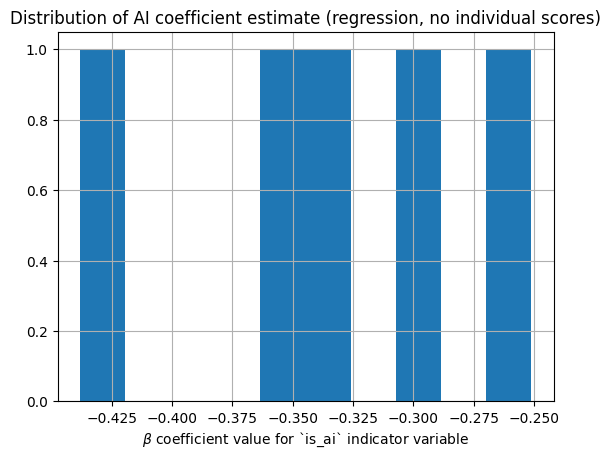

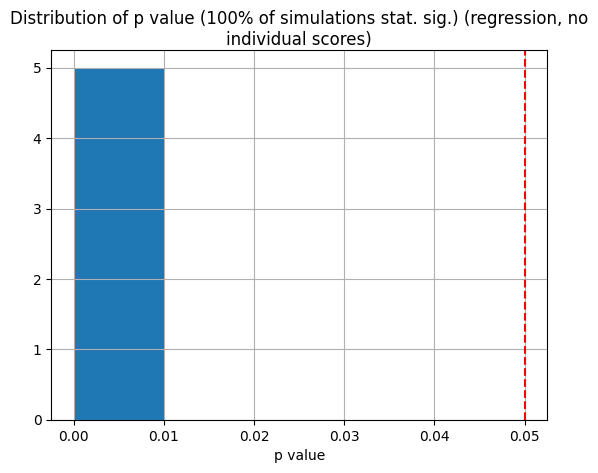

binomial


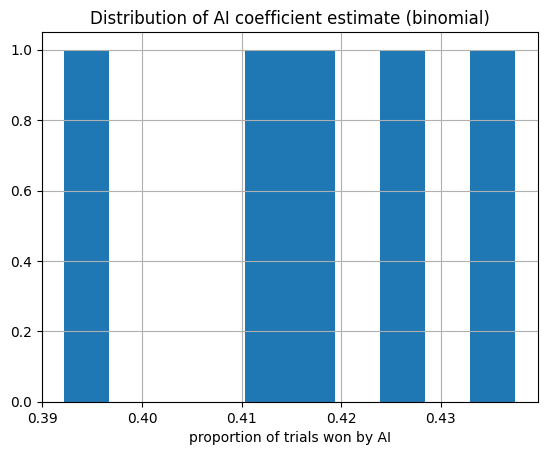

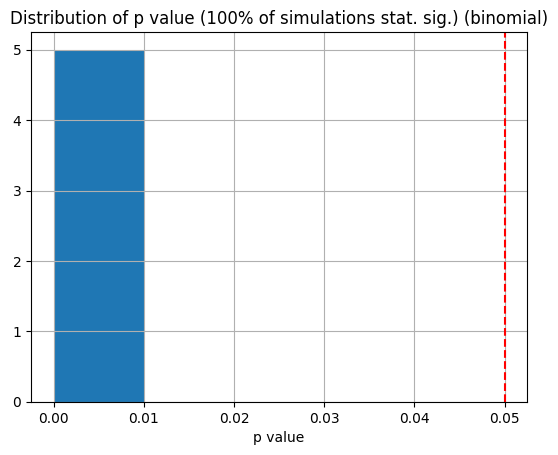

Initializing NUTS using jitter+adapt_diag...


bayes non ind


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 6 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ability, beta_ai]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 5 seconds.


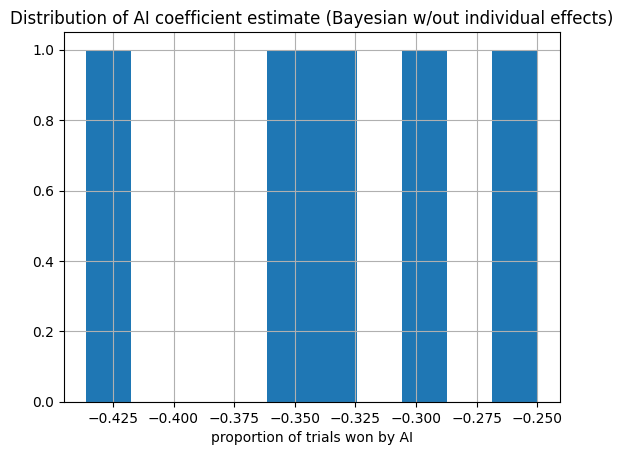

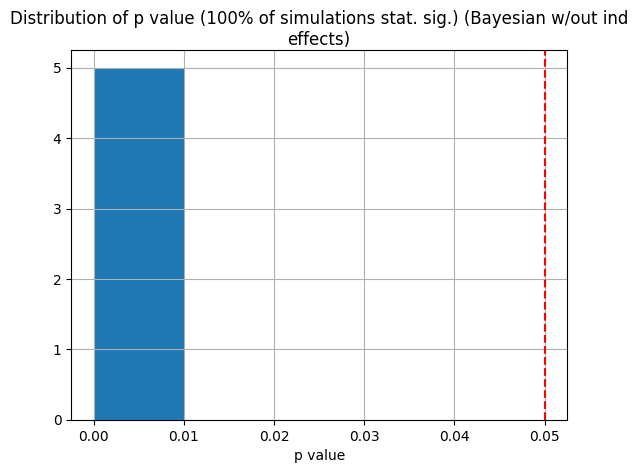

In [75]:
test_df = run_simulation_n_times('test', N = 5, plot=True, Model_ABILITIES = [0.9,0.9,0.9,0.9], avg_participant_skill=5, N_PARTICIPANTS=40)

There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)


[(np.float64(0.78), np.float64(0.78)), (np.float64(0.88), np.float64(0.88)), (np.float64(0.98), np.float64(0.98)), (np.float64(0.94), np.float64(0.94)), (np.float64(0.98), np.float64(0.98))]


<Axes: >

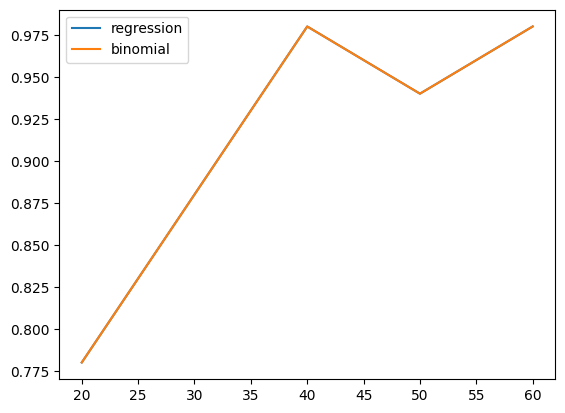

In [ ]:
def test_participant_num(N):
    return run_simulation_n_times('test', N=50, plot=False, Model_ABILITIES = [0.9]*4, avg_participant_skill=5, N_PARTICIPANTS=N)

res = [test_participant_num(N) for N in [20, 30, 40, 50, 60]]
print(res)
    
pd.DataFrame(res, columns=['regression', 'binomial'], index = [20, 30, 40, 50, 60]).plot()


- test for non-difference
- seperability
- more complicated model

Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


Warning messages:
1: Ability modelled by predictors but no random effects 
2: Ability modelled by predictors but no random effects 


Warning messages:
1: Ability modelled by predictors but no random effects
2: Ability modelled by predictors but no random effects


<Axes: >

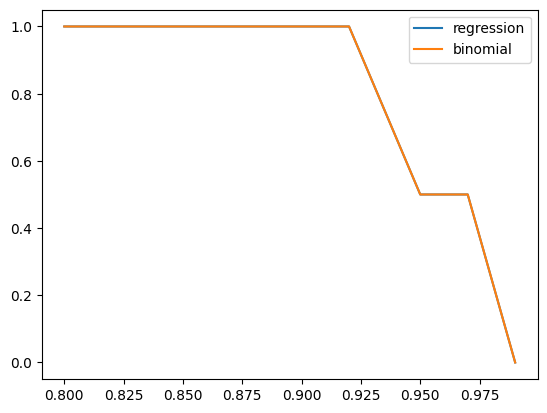

In [ ]:
def test_model_skill(skill):
    return run_simulation_n_times('test', N=2, plot=False, Model_ABILITIES = [skill]*4, avg_participant_skill=5, N_PARTICIPANTS=40)

skills = [0.8, 0.85, 0.9, 0.92, 0.95, 0.97, 0.99]

res_model_skill = [test_model_skill(skill) for skill in skills]
# print(res_model_skill)

pd.DataFrame(res_model_skill, columns=['regression', 'binomial'], index = skills).plot()

There were 20 warnings (use warnings() to see them)


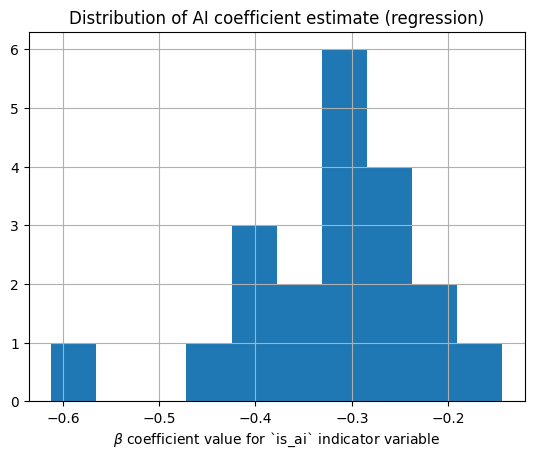

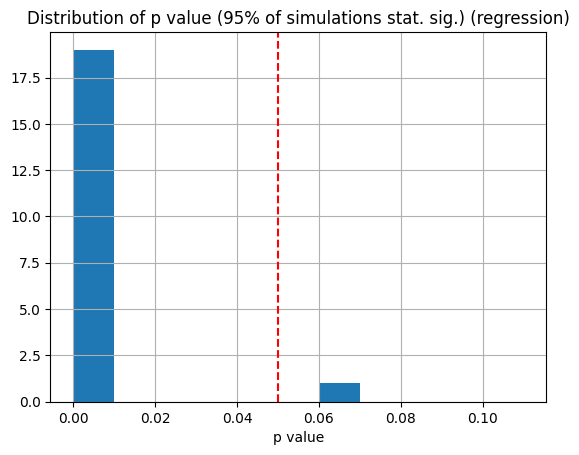

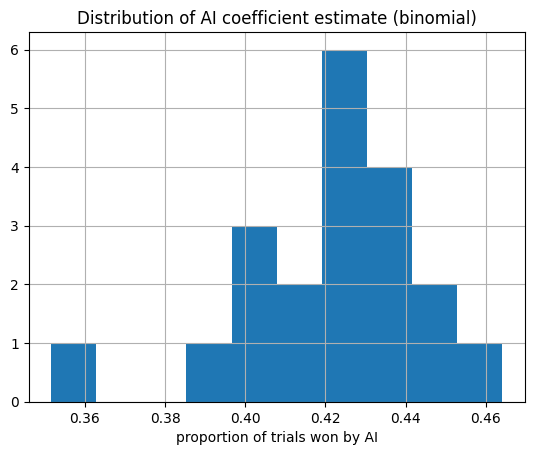

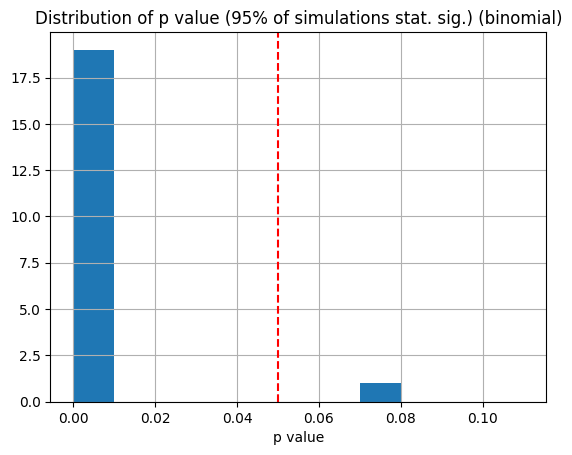

In [ ]:

cProfile.run(
    """run_simulation_n_times('test', N = 20, Model_ABILITIES = [0.9,0.9,0.9,0.9], avg_participant_skill=5, N_PARTICIPANTS=40)""", 
    'profiling.prof'
)

## Bayesian approach for small data when estimating fixed individual effects

# Calibration

0.99 4.6000000000000005
0.9 2.2
0.75 1.1
0.55 0.2


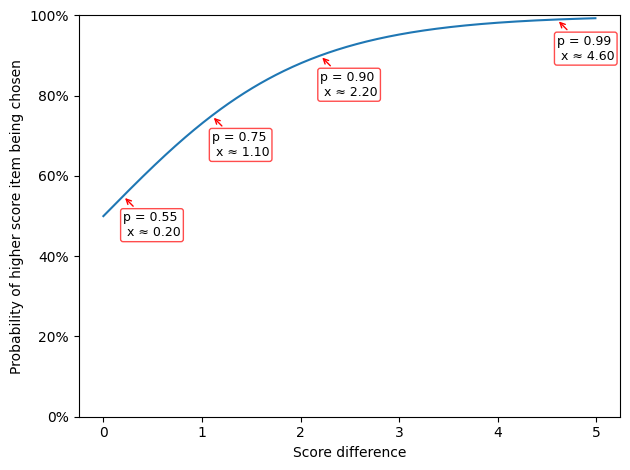

In [ ]:
x = np.arange(0, 5, 0.01)
y = 1 - score_diff_to_probability(x) 

probs_of_interest = [0.99, 0.9, 0.75, 0.55]
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    print(p, x[idx])
# if the diff is positive, it means that B has better score than A, (so p(A>B) < 0.5) . 
# So we take 1 - {this function} for the purposes of this calibration, which gives p(B>A)
plt.plot(x, y)
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    x_val = x[idx]

    # Vertical & horizontal guides
    # plt.axvline(x_val, color='red', linestyle='--', lw=1, alpha=0.7)
    # plt.axhline(p, color='gray', linestyle=':', lw=1, alpha=0.4)

    # Annotate with arrow
    plt.annotate(
        f'p = {p:.2f}\n x ≈ {x_val:.2f}',
        xy=(x_val, p),
        xytext=(x_val, p - 0.1),
        textcoords='data',
        arrowprops=dict(arrowstyle='->', color='red', lw=1),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.7)
    )
plt.ylim((0,1))
plt.xlabel('Score difference')
plt.ylabel('Probability of higher score item being chosen')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.tight_layout()

In [ ]:
comparisons = pd.Series([
    (0, 1),
    (0.5, 1),
    (0.75, 1),
    (0.9, 1),
    (0.95, 1)
])
skill = 5
comparisons.map(lambda el: score_diff_to_probability(skill * (el[0] - el[1])))

0    0.993307
1    0.924142
2    0.777300
3    0.622459
4    0.562177
dtype: float64

# Further notes

To do:
- no repeats within trials 
- sampling without replacement 
- use same trial block format as in experimental design (done)
- think about what characteristicness per artist is meant to represent (done)
- how to calibrate participant baseline skill for simulations (roughly done, see calibration)

## What simulations do we want to run?

### Sense checks:
- Increasing the # of participants should increase power
- Increasing the skill of participants should increase power
- Reducing avg. characteristicness of artists should increase power
- Reducing the mimicing ability of Models should reduce power
- Maintaining average Model ability but increasing spread should decrease power

### Calibration:
- Need to calibrate how skill influences probability. Maybe fix AI characteristicness at 0.6 and human at 0.7 (so it's a fixed 0.1 diff), then vary

# Other methods:
- Bradley-Terry model w/ regression: done
- Simple method: proportion of wins to AI, run a chi squared test for independence

### Specification of Bradley-Terry model:

$$P(A > B) = \frac{1}{1 + e^{\lambda_B - \lambda_A}},$$
where
$$\lambda_A = \beta_A +  \beta_0 \cdot is\_ai_A + \beta_1 \cdot Model_1 + \cdots + \beta_m \cdot Model_{m}  + \beta_{m+1} \cdot is\_anachronistic + \epsilon, \\ \epsilon \sim N(0, \theta)$$


$$\lambda_A = \beta_A$$

$$\lambda_A = \beta_0 \cdot is\_ai_A  $$

- Improve Bayesian stuff (faster, better convergence)
- multinomial regression / whatever other approaches make sense
- look at 2AFC papers in: PNAS, Nature, Cognitive Science
- **Experimentology** <-- read